# Bayesian Weather Network

https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data

#### Extract Weather Data

Check if the expected CSV file exists in the current directory. If it is not present, open the archive.zip and extract.

In [1]:
import os, zipfile

if not os.path.exists("city_attributes.csv"):
    with zipfile.ZipFile("archive.zip", "r") as zip_file:
        zip_file.extractall(".")

#### Build per-city Weather Data Frames

Load the four weather CSV files using the timestamp column as the index. Convert the indexes to datetimes and sort the rows by time. Compute the intersection of city columns present in all files. Define a helper that selects a particular city’s series. Coerce values to numeric and interpolate missing points by time. Drop any remaining missing rows and build a dictionary from the city to its cleaned frame. Show a few rows for three example cities.

In [2]:
import pandas as pd

df_temp = pd.read_csv("temperature.csv", index_col="datetime")
df_humid = pd.read_csv("humidity.csv", index_col="datetime")
df_pressure = pd.read_csv("pressure.csv", index_col="datetime")
df_wind_speed = pd.read_csv("wind_speed.csv", index_col="datetime")

for df in (df_temp, df_humid, df_pressure, df_wind_speed):
    df.index = pd.to_datetime(df.index, errors="coerce")
    df.sort_index(inplace=True)

cities = sorted(
    set(df_temp.columns)
    & set(df_humid.columns)
    & set(df_pressure.columns)
    & set(df_wind_speed.columns)
)

def build_city(c):
    df = pd.concat(
        [
            df_temp[[c]].rename(columns={c: "Temperature_K"}),
            df_humid[[c]].rename(columns={c: "Humidity_Pct"}),
            df_pressure[[c]].rename(columns={c: "Pressure_hPa"}),
            df_wind_speed[[c]].rename(columns={c: "Wind_Speed"}),
        ],
        axis=1,
    )
    
    df = df.apply(pd.to_numeric, errors="coerce")
    df = df.interpolate(method="time").dropna()
    
    return df


city_data_frames = {c: build_city(c) for c in cities}

print(f"{len(city_data_frames)} city data frames built.")

print(f"\n{cities[0]}:")
print(city_data_frames[cities[0]].head())

print(f"\n{cities[22]}:")
print(city_data_frames[cities[22]].head())

print(f"\n{cities[31]}:")
print(city_data_frames[cities[31]].head())

36 city data frames built.

Albuquerque:
                     Temperature_K  Humidity_Pct  Pressure_hPa  Wind_Speed
datetime                                                                  
2012-10-01 13:00:00     285.120000          50.0        1024.0         4.0
2012-10-01 14:00:00     285.154558          49.0        1024.0         4.0
2012-10-01 15:00:00     285.233952          49.0        1024.0         4.0
2012-10-01 16:00:00     285.313345          49.0        1024.0         4.0
2012-10-01 17:00:00     285.392738          49.0        1024.0         4.0

Nashville:
                     Temperature_K  Humidity_Pct  Pressure_hPa  Wind_Speed
datetime                                                                  
2012-10-01 13:00:00     287.410000         100.0        1005.0         4.0
2012-10-01 14:00:00     287.421360          99.0        1004.0         4.0
2012-10-01 15:00:00     287.454637          99.0        1004.0         4.0
2012-10-01 16:00:00     287.487914          99.

#### Build Categorical Data Per City

Define hour labels and low-medium-high labels. Set bin edges for time of day. Create 24 day of year bins with string labels. Provide a helper that quantile cuts a numeric series and assigns base-prefixed Low, Medium, or High labels, adapting if bins are dropped. Copy each city frame. Compute temperature in Fahrenheit. Bucket timestamps into an hour category. Quantize temperature, humidity, pressure, and wind into labeled categories. Bucket the day of year into a seasonal bin. Select the weather categories plus the hour and day of year columns and cast them to categorical dtype. Return the transformed frame. Build a dictionary of these frames for all cities. Print sample rows for one city.

In [3]:
import numpy as np

hour_labels = ["Night", "Morning", "Day", "Evening"]
lmh_labels = ["Low", "Medium", "High"]
time_of_day_bins = [-1, 5, 11, 17, 23]

day_of_year_bin_count = 24
day_of_year_bins = np.linspace(0, 366, day_of_year_bin_count + 1)
day_of_year_labels = [f"Day_Of_Year_{i:02d}" for i in range(day_of_year_bin_count)]


def get_named_quantiles(series, base_name):
    quantiles = 3
    tmp = pd.qcut(series, q=quantiles, duplicates="drop")
    size = tmp.cat.categories.size
    names = lmh_labels[:size]
    labels = [f"{base_name}_{n}" for n in names]

    return pd.qcut(series, q=quantiles, labels=labels, duplicates="drop")


def rebuild_city_df(city_df):
    df = city_df.copy()

    df["Temperature_F"] = (df["Temperature_K"] - 273) * (9 / 5) + 32
    
    df["Hour_Category"] = pd.cut(
        df.index.hour,
        bins=time_of_day_bins, 
        labels=hour_labels, 
        include_lowest=True
    ).astype(str)

    df["Temp_Category"] = get_named_quantiles(
        df["Temperature_F"], "Temp_Category"
    ).astype(str)
    
    df["Humidity_Category"] = get_named_quantiles(
        df["Humidity_Pct"], "Humidity_Category"
    ).astype(str)
    
    df["Pressure_Category"] = get_named_quantiles(
        df["Pressure_hPa"], "Pressure_Category"
    ).astype(str)

    df["Wind_Category"] = get_named_quantiles(
        df["Wind_Speed"], "Wind_Category"
    ).astype(str)

    df["Day_Of_Year_Bin"] = pd.cut(
        df.index.dayofyear,
        bins=day_of_year_bins,
        labels=day_of_year_labels,
        include_lowest=True,
    ).astype(str)

    network_df = df[
        [
            "Temp_Category",
            "Humidity_Category",
            "Pressure_Category",
            "Wind_Category",
            "Hour_Category",
            "Day_Of_Year_Bin",
        ]
    ].copy()

    for c in network_df.columns:
        network_df[c] = network_df[c].astype("category")

    return network_df


network_data_frames = {c: rebuild_city_df(city_data_frames[c]) for c in cities}

print(f"Network data frames count: {len(network_data_frames)}")

city = cities[22]
print(f"\n{city}:")
print(network_data_frames[city].head())

Network data frames count: 36

Nashville:
                            Temp_Category       Humidity_Category  \
datetime                                                            
2012-10-01 13:00:00  Temp_Category_Medium  Humidity_Category_High   
2012-10-01 14:00:00  Temp_Category_Medium  Humidity_Category_High   
2012-10-01 15:00:00  Temp_Category_Medium  Humidity_Category_High   
2012-10-01 16:00:00  Temp_Category_Medium  Humidity_Category_High   
2012-10-01 17:00:00  Temp_Category_Medium  Humidity_Category_High   

                         Pressure_Category       Wind_Category Hour_Category  \
datetime                                                                       
2012-10-01 13:00:00  Pressure_Category_Low  Wind_Category_High           Day   
2012-10-01 14:00:00  Pressure_Category_Low  Wind_Category_High           Day   
2012-10-01 15:00:00  Pressure_Category_Low  Wind_Category_High           Day   
2012-10-01 16:00:00  Pressure_Category_Low  Wind_Category_High           D

#### Define Network Diagram Display Helper

Create a new graph and add the provided edges. Compute node positions with Graphviz via pydot_layout. Build display labels by replacing underscores with spaces. Measure the layout bounds, add padding, and convert points to inches for the figure size. Create a matplotlib axes and draw nodes. Compute the edge margin from the node size so arrowheads stop short of the node borders. Draw edges with that margin and slim lines. Render labels at each node. Set padded axis limits. Hide the axes. Show the plot.

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import pydot_layout


def draw_network(edges):
    graph = nx.DiGraph()
    graph.add_edges_from(edges)

    positions = pydot_layout(graph, prog="dot")

    labels = {n: n.replace("_", " ") for n in graph.nodes()}

    xs, ys = zip(*positions.values())
    xmin, xmax = min(xs), max(xs)
    ymin, ymax = min(ys), max(ys)
    
    pad = 100
    width_in = max(6, (xmax - xmin + 2 * pad) / 72)
    height_in = max(3, (ymax - ymin + 2 * pad) / 72)

    _, ax = plt.subplots(figsize=(width_in, height_in))

    node_size = 1000

    nx.draw_networkx_nodes(
        graph,
        positions,
        node_color="#00F7FF",
        node_size=node_size,
        edgecolors="black",
        linewidths=0.5,
        ax=ax,
    )

    margin = (node_size ** 0.5) / 2

    nx.draw_networkx_edges(
        graph,
        positions,
        arrows=True,
        arrowstyle="->",
        arrowsize=16,
        width=0.7,
        ax=ax,
        min_source_margin=margin,
        min_target_margin=margin,
    )
    nx.draw_networkx_labels(graph, positions, labels, font_size=11, font_color="#003082", ax=ax)

    ax.set_xlim(xmin - pad, xmax + pad)
    ax.set_ylim(ymin - pad, ymax + pad)
    ax.set_axis_off()
    plt.show()

#### Define the Network

Define the directed edges for the model structure. Construct a discrete Bayesian network for every city using the edges. Print the total number of models. Display an example city with its nodes and edges. Render the network diagram.

Models count: 36

Nashville:
Nodes: ['Day_Of_Year_Bin', 'Temp_Category', 'Hour_Category', 'Humidity_Category', 'Pressure_Category', 'Wind_Category']
Edges: [('Day_Of_Year_Bin', 'Temp_Category'), ('Day_Of_Year_Bin', 'Humidity_Category'), ('Day_Of_Year_Bin', 'Pressure_Category'), ('Day_Of_Year_Bin', 'Wind_Category'), ('Hour_Category', 'Temp_Category'), ('Hour_Category', 'Humidity_Category'), ('Hour_Category', 'Wind_Category'), ('Pressure_Category', 'Wind_Category')]


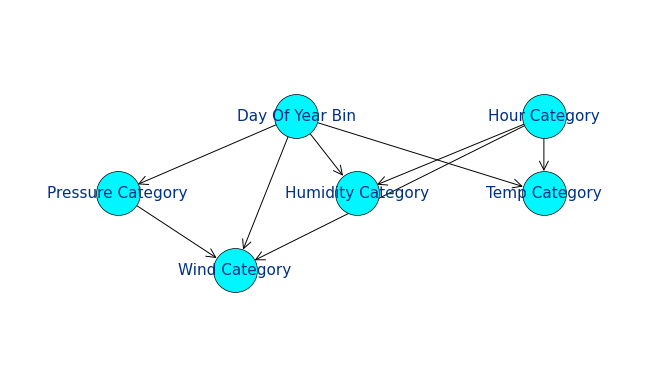

In [5]:
from pgmpy.models import DiscreteBayesianNetwork

edges = [
    ("Day_Of_Year_Bin", "Temp_Category"),
    ("Hour_Category", "Temp_Category"),
    ("Day_Of_Year_Bin", "Humidity_Category"),
    ("Hour_Category", "Humidity_Category"),
    ("Day_Of_Year_Bin", "Pressure_Category"),
    ("Day_Of_Year_Bin", "Wind_Category"),
    ("Hour_Category", "Wind_Category"),
    ("Pressure_Category", "Wind_Category"),
]

models = {c: DiscreteBayesianNetwork(edges) for c in cities}

print(f"Models count: {len(models)}")

c = cities[22]
print(f"\n{c}:")
print(f"Nodes: {models[c].nodes()}")
print(f"Edges: {models[c].edges()}")

draw_network(edges)

#### Train Network

Import the Bayesian estimator and silence noisy library logging. Fit each city’s network using the categorical data. Use the BDeu prior with an equivalent sample size of 10. Display conditional probability tables for one example city. Print cardinality for each city.

In [6]:
from pgmpy.estimators import BayesianEstimator

import logging
logging.getLogger("pgmpy").setLevel(logging.WARNING)

for c in cities:
    models[c].fit(
        network_data_frames[c],
        estimator=BayesianEstimator,
        prior_type="BDeu",
        equivalent_sample_size=10,
    )
    # assert models[c].check_model(), f"Invalid network for {c}"


city = cities[22]

print(f"\nConditional Probability Distributions for {city}:\n")

for cpd in models[city].get_cpds():
    print(cpd.variable, "Cardinality:", cpd.cardinality)


Conditional Probability Distributions for Nashville:

Day_Of_Year_Bin Cardinality: [24]
Temp_Category Cardinality: [ 3 24  4]
Humidity_Category Cardinality: [ 3 24  4]
Pressure_Category Cardinality: [ 3 24]
Wind_Category Cardinality: [ 3 24  4  3]
Hour_Category Cardinality: [4]


#### Create Inference Objects

Import the variable elimination inference class. Build a dictionary that maps each city to an inference object created from its fitted model. Use the resulting city objects to run queries during inference.

In [7]:
from pgmpy.inference import VariableElimination

cities_for_inference = {c: VariableElimination(models[c]) for c in cities}

#### Create Inference Query Helper

Map variable names to human-friendly labels. Print the city, date, and time with the hour bucket. Convert the dictionary into Low, Medium, and High percentages. Loop over temperature, humidity, pressure, and wind and pull the most likely state. Format the three percentages and print a row for each condition. Parse the input timestamp and bucket the day of year and hour into categories. Build evidence from those two buckets. Select the target variables to look up the city’s inference object. Query for each target with the evidence. Store the most likely state and the full probability map. Build a small context object and pretty print the results.

In [8]:
def get_column_name(name):
    return {
        "Temp_Category": "Temp",
        "Humidity_Category": "Humidity",
        "Pressure_Category": "Pressure",
        "Wind_Category": "Wind",
    }.get(name, name)

def pretty_print_result(context, results):
    dt = context["dt"]
    hour_label = context["hour_label"]
    city = context["city"]

    print(f"City: {city}")
    print(f"Date: {dt.date().isoformat()}")
    print(f"Time: {dt.strftime('%H:%M')} ({hour_label})\n")

    header = f"{'Condition':13} {'Likely':12}  {'Low':^{12}}  {'Medium':^{12}}  {'High':^{13}}"
    print(header)
    print("-" * 66)

    def probability_percentage(distribution, wanted):
        for s, p in distribution.items():
            if s.split("_")[-1].capitalize() == wanted:
                return float(p) * 100.0
        
        return 0.0

    for name in [
        "Temp_Category",
        "Humidity_Category",
        "Pressure_Category",
        "Wind_Category",
    ]:
        likely = results[name]["likely"].split("_")[-1].capitalize()

        probabilities = results[name]["probabilities"]
        low = f"{probability_percentage(probabilities, 'Low'):.1f}%"
        med = f"{probability_percentage(probabilities, 'Medium'):.1f}%"
        high = f"{probability_percentage(probabilities, 'High'):.1f}%"

        print(
            f"{get_column_name(name):13} {likely:12}  {low:>8}  {med:>{13}}  {high:>{12}}"
        )
    
    print("\n")


def infer_weather(city, date_str):
    dt = pd.to_datetime(date_str)

    day_of_year = pd.cut(
        pd.Index([dt.dayofyear]),
        bins=day_of_year_bins,
        labels=day_of_year_labels,
        include_lowest=True,
    )[0]

    hour = pd.cut(
        pd.Index([dt.hour]),
        bins=time_of_day_bins,
        labels=hour_labels,
        include_lowest=True,
    )[0]

    targets = [
        "Temp_Category",
        "Humidity_Category",
        "Pressure_Category",
        "Wind_Category",
    ]

    evidence = {"Day_Of_Year_Bin": str(day_of_year), "Hour_Category": str(hour)}
    inferred_city = cities_for_inference[city]

    results = {}
    for name in targets:
        factor = inferred_city.query(variables=[name], evidence=evidence, show_progress=False)
        states = list(factor.state_names[name])
        probabilities = factor.values

        results[name] = {
            "likely": states[int(probabilities.argmax())],
            "probabilities": dict(zip(states, probabilities.round(4))),
        }

    context = {"dt": dt, "hour_label": str(hour), "evidence": evidence, "city": city}
    pretty_print_result(context, results)

#### Infer Weather By City, Date, and Time

Call the inference function for a few example cities and timestamps to compute weather categories using day and hour evidence, then print the formatted results for each call.

In [9]:
infer_weather(cities[0], "2018-07-04 09:00:00")
infer_weather(cities[22], "2019-08-10 19:00:00")
infer_weather(cities[31], "2020-11-29 04:00:00")

City: Albuquerque
Date: 2018-07-04
Time: 09:00 (Morning)

Condition     Likely            Low          Medium         High     
------------------------------------------------------------------
Temp          High              0.0%          35.3%         64.7%
Humidity      High             15.8%          21.8%         62.4%
Pressure      Medium           29.3%          46.1%         24.6%
Wind          Low              61.9%          21.2%         16.9%


City: Nashville
Date: 2019-08-10
Time: 19:00 (Evening)

Condition     Likely            Low          Medium         High     
------------------------------------------------------------------
Temp          High              0.0%           0.2%         99.8%
Humidity      Low              61.3%          28.0%         10.7%
Pressure      Low              48.8%          37.0%         14.2%
Wind          Medium           28.7%          47.1%         24.1%


City: San Francisco
Date: 2020-11-29
Time: 04:00 (Night)

Condition     Likely  

#### Infer Approximate Date And Hour From A Temperature

Convert the city’s temperatures to Fahrenheit. Compute quantile cut points on that history. Map the input temperature to a labeled category using the cut points. Query the network for the seasonal bin using that category as evidence. Rank the seasonal bins by probability and take the top three. Convert each bin to an approximate month and day by using the bin’s center. Query the network for the hour bucket using the same category as evidence. Print the city and the input temperature. Print the top three dates with percentages and the most likely hour bucket.

In [10]:
def temp_to_category(city, temp):
    series_frame = (city_data_frames[city]["Temperature_K"] - 273) * (9 / 5) + 32
    _, bins = pd.qcut(series_frame, q=3, duplicates="drop", retbins=True)
    last_index = len(bins) - 1
    names = lmh_labels[:last_index]

    labels = [f"Temp_Category_{n}" for n in names]
    
    x = float(temp)
    eps = 1e-9
    x = min(max(x, bins[0] + eps), bins[-1] - eps)
    cat = pd.cut(pd.Index([x]), bins=bins, labels=labels, include_lowest=True)[0]

    return str(cat)

def label_to_day_of_year(label):
    index = day_of_year_labels.index(label)
    start = day_of_year_bins[index]
    end = day_of_year_bins[index + 1]
    
    center = max(1, min(365, int(round((start + end) / 2))))
    base = pd.Timestamp("2013-01-01") + pd.Timedelta(days=center - 1)
    
    return base.strftime("%b %d"), center

def infer_dates_from_temp(city, temp):
    temp_category = temp_to_category(city, temp)
    inferred_city = cities_for_inference[city]

    day_of_year_factor = inferred_city.query(
        variables=["Day_Of_Year_Bin"],
        evidence={"Temp_Category": temp_category},
        show_progress=False,
    )
    doy_states = list(day_of_year_factor.state_names["Day_Of_Year_Bin"])
    doy_probs = day_of_year_factor.values

    order = list(reversed(doy_probs.argsort()))[:3]
    top_dates = [(doy_states[i], float(doy_probs[i])) for i in order]

    hour_factor = inferred_city.query(
        variables=["Hour_Category"],
        evidence={"Temp_Category": temp_category},
        show_progress=False,
    )
    hour_states = list(hour_factor.state_names["Hour_Category"])
    hour_probs = hour_factor.values
    hour_label = hour_states[int(hour_probs.argmax())]

    print(f"City: {city}")
    print(f"Temperature: {temp}\n")

    print("Best Dates:")
    for label, probability in top_dates:
        month_day, _ = label_to_day_of_year(label)
        print(f"  {month_day}: {probability * 100:.1f}%")

    print(f"\nBest Hour: {hour_label}\n\n")

#### Infer Best Dates and Time by City and Temperature

Call the date inference helper for three cities with given temperatures. Map each temperature to the city’s learned temperature category. Query the network to infer the most likely seasonal bins and hour bucket from that category. Print the top date candidates with percentages and the most likely hour for each call.

In [11]:
infer_dates_from_temp(cities[0], 75)
infer_dates_from_temp(cities[22], 80)
infer_dates_from_temp(cities[31], 42)

City: Albuquerque
Temperature: 75

Best Dates:
  Jun 24: 10.7%
  Jul 25: 10.3%
  Jul 10: 10.0%

Best Hour: Evening


City: Nashville
Temperature: 80

Best Dates:
  Jun 24: 11.1%
  Aug 24: 10.4%
  Jul 10: 10.2%

Best Hour: Evening


City: San Francisco
Temperature: 42

Best Dates:
  Dec 24: 10.1%
  Jan 08: 10.0%
  Jan 23: 8.0%

Best Hour: Morning




#### Network Evaluation and Verification

Sort the per-city categorical frame. Compute a time-based start point from the given fraction. Take the remaining as the test set and subsample it. Look up the city’s inference object. Define the four target variables. For each target, iterate over the test rows and build date and hour evidence from the row. Query the posterior for the target and select the most likely state. Collect predictions and truths. Compute accuracy as the fraction correct. Compute F1 with the target’s categorical labels. Store the metrics and counts. Print metrics per target. Repeat for three example cities.

In [12]:
import numpy as np
from sklearn.metrics import f1_score

def evaluate_city_accuracy(city):
    network_df = network_data_frames[city].sort_index()
    start = int(len(network_df) * 0.8)

    test = network_df.iloc[start:]
    test = test.sample(2000, random_state=17).sort_index()

    inferred_city = cities_for_inference[city]

    targets = [
        "Temp_Category",
        "Humidity_Category",
        "Pressure_Category",
        "Wind_Category",
    ]

    rows = []

    for target in targets:
        y_true, y_pred = [], []

        for _, row in test.iterrows():
            evidence = {
                "Day_Of_Year_Bin": row["Day_Of_Year_Bin"],
                "Hour_Category": row["Hour_Category"]
            }
            factor = inferred_city.query([target], evidence=evidence, show_progress=False)

            states = list(factor.state_names[target])
            y_pred.append(states[int(factor.values.argmax())])
            y_true.append(row[target])

        accuracy = np.mean(np.array(y_true) == np.array(y_pred))
        labels = list(network_df[target].cat.categories)

        f1 = f1_score(
            y_true,
            y_pred,
            labels=labels,
            average="macro",
            zero_division=0
        )

        rows.append((target, accuracy, f1, len(y_true)))

    print(f"City: {city}  Test size: {len(test)}\n")
    print(f"{'Target':20} {'Accuracy':>8} {'F1':>12} {'Count':>8}")

    for target, accuracy, f1, count in rows:
        f1s = f"{f1:.3f}" if np.isfinite(f1) else "n/a"
        print(f"{target:20} {accuracy:8.3f} {f1s:>12} {count:8d}")


for c in [cities[0], cities[22], cities[31]]:
    evaluate_city_accuracy(c)
    print("\n")

City: Albuquerque  Test size: 2000

Target               Accuracy           F1    Count
Temp_Category           0.721        0.717     2000
Humidity_Category       0.533        0.499     2000
Pressure_Category       0.412        0.391     2000
Wind_Category           0.483        0.312     2000


City: Nashville  Test size: 2000

Target               Accuracy           F1    Count
Temp_Category           0.664        0.657     2000
Humidity_Category       0.543        0.538     2000
Pressure_Category       0.485        0.485     2000
Wind_Category           0.513        0.452     2000


City: San Francisco  Test size: 2000

Target               Accuracy           F1    Count
Temp_Category           0.664        0.664     2000
Humidity_Category       0.519        0.508     2000
Pressure_Category       0.451        0.427     2000
Wind_Category           0.449        0.445     2000




#### Increase Edges To Improve Network

Re-define the edges including temperature as a parent of humidity, pressure, and wind. Create a new Bayesian network for each city using the new edges. Print the total number of models. Select an example city and print its nodes and edges. Draw a new network diagram using the new edges.

Models count: 36

Nashville:
Nodes: ['Day_Of_Year_Bin', 'Temp_Category', 'Hour_Category', 'Humidity_Category', 'Pressure_Category', 'Wind_Category']
Edges: [('Day_Of_Year_Bin', 'Temp_Category'), ('Day_Of_Year_Bin', 'Humidity_Category'), ('Day_Of_Year_Bin', 'Pressure_Category'), ('Day_Of_Year_Bin', 'Wind_Category'), ('Temp_Category', 'Humidity_Category'), ('Temp_Category', 'Pressure_Category'), ('Temp_Category', 'Wind_Category'), ('Hour_Category', 'Temp_Category'), ('Hour_Category', 'Humidity_Category'), ('Hour_Category', 'Wind_Category'), ('Pressure_Category', 'Wind_Category')]


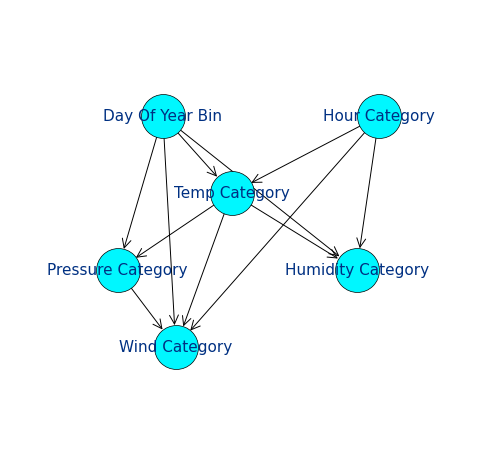

In [13]:
edges = [
    ("Day_Of_Year_Bin", "Temp_Category"),
    ("Hour_Category", "Temp_Category"),
    ("Day_Of_Year_Bin", "Humidity_Category"),
    ("Hour_Category", "Humidity_Category"),
    ("Temp_Category", "Humidity_Category"),
    ("Day_Of_Year_Bin", "Pressure_Category"),
    ("Temp_Category", "Pressure_Category"),
    ("Day_Of_Year_Bin", "Wind_Category"),
    ("Hour_Category", "Wind_Category"),
    ("Pressure_Category", "Wind_Category"),
    ("Temp_Category", "Wind_Category"),
]

models = {c: DiscreteBayesianNetwork(edges) for c in cities}

print(f"Models count: {len(models)}")

city = cities[22]
print(f"\n{city}:")
print(f"Nodes: {models[city].nodes()}")
print(f"Edges: {models[city].edges()}")

draw_network(edges)

#### Re-fit the Networks

Re-fit each city’s model on its categorical data using the BDeu prior. Pick an example city and print its probability distributions cardinalities. Create a new dictionary of inference objects. Replace the active city inference mappings with the new dictionary.

In [14]:
for city in cities:
    models[city].fit(
        network_data_frames[city],
        estimator=BayesianEstimator,
        prior_type="BDeu",
        equivalent_sample_size=10,
    )
    # assert models[city].check_model(), f"Invalid network for {city}"


city = cities[22]

print(f"\nConditional Probability Distributions for {city}:\n")

for cpd in models[city].get_cpds():
    print(cpd.variable, "Cardinality:", cpd.cardinality)

cities_for_inference_2 = {city: VariableElimination(models[city]) for city in cities}
cities_for_inference = cities_for_inference_2


Conditional Probability Distributions for Nashville:

Day_Of_Year_Bin Cardinality: [24]
Temp_Category Cardinality: [ 3 24  4]
Humidity_Category Cardinality: [ 3 24  4  3]
Pressure_Category Cardinality: [ 3 24  3]
Wind_Category Cardinality: [ 3 24  4  3  3]
Hour_Category Cardinality: [4]


#### Re-evaluate Accuracy and F1

Call the evaluation function for a few sample cities. Compute accuracy and F1 for each city. Print the metrics.

In [15]:
for city in [cities[0], cities[22], cities[31]]:
    evaluate_city_accuracy(city)
    print("\n")

City: Albuquerque  Test size: 2000

Target               Accuracy           F1    Count
Temp_Category           0.721        0.717     2000
Humidity_Category       0.533        0.499     2000
Pressure_Category       0.433        0.411     2000
Wind_Category           0.497        0.332     2000


City: Nashville  Test size: 2000

Target               Accuracy           F1    Count
Temp_Category           0.664        0.657     2000
Humidity_Category       0.543        0.538     2000
Pressure_Category       0.459        0.458     2000
Wind_Category           0.513        0.452     2000


City: San Francisco  Test size: 2000

Target               Accuracy           F1    Count
Temp_Category           0.664        0.664     2000
Humidity_Category       0.519        0.508     2000
Pressure_Category       0.484        0.433     2000
Wind_Category           0.448        0.444     2000




#### New diagram rendering

Render the network edges with city names and smaller.

In [16]:
def draw_network(edges, city):
    graph = nx.DiGraph()
    graph.add_edges_from(edges)

    positions = pydot_layout(graph, prog="dot")
    labels = {n: n.replace("_", " ") for n in graph.nodes()}

    xs, ys = zip(*positions.values())
    xmin, xmax = min(xs), max(xs)
    ymin, ymax = min(ys), max(ys)

    pad = 100
    width_in = max(4, (xmax - xmin + 2 * pad) / 144)
    height_in = max(2, (ymax - ymin + 2 * pad) / 144)

    _, ax = plt.subplots(figsize=(width_in, height_in))

    node_size = 600
    nx.draw_networkx_nodes(
        graph,
        positions,
        node_color="#00F7FF",
        node_size=node_size,
        edgecolors="black",
        linewidths=0.5,
        ax=ax,
    )

    margin = (node_size ** 0.5) / 2
    nx.draw_networkx_edges(
        graph,
        positions,
        arrows=True,
        arrowstyle="->",
        arrowsize=16,
        width=0.7,
        ax=ax,
        min_source_margin=margin,
        min_target_margin=margin,
    )
    nx.draw_networkx_labels(
        graph, positions, labels, font_size=9, font_color="#003082", ax=ax
    )

    ax.set_title(f"Bayesian Network: {city}", fontsize=13, color="#003082")

    ax.set_xlim(xmin - pad, xmax + pad)
    ax.set_ylim(ymin - pad, ymax + pad)
    ax.set_axis_off()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

#### Learn Edges From Data

Run hill climbing search on each city frame to learn a directed acyclic graph with at most three parents per node, then build a Bayesian network from the edges. Update the active inference objects with new ones based on the new learned networks. Render a diagram for each city using the learned edge set so the different structure can be inspected.


Learned Bayesian Network for Albuquerque:


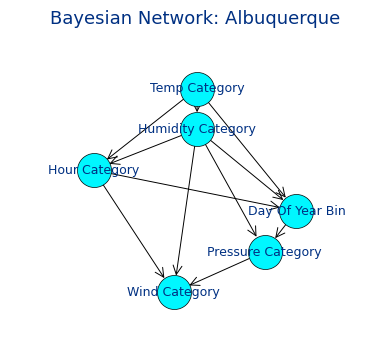


Learned Bayesian Network for Nashville:


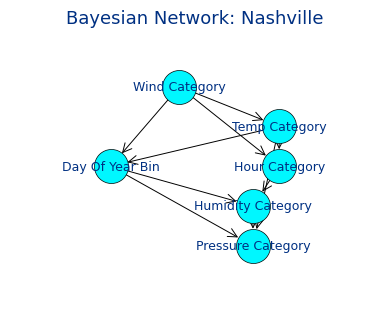


Learned Bayesian Network for San Francisco:


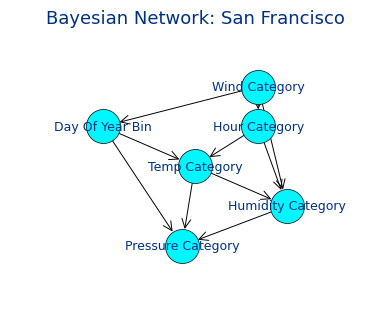

In [17]:
from pgmpy.estimators import HillClimbSearch, BIC

learned_models = {}
for c in cities_for_inference:
    df = network_data_frames[c]
    hc = HillClimbSearch(df)
    learned_dag = hc.estimate(
        scoring_method=BIC(df), max_indegree=3, show_progress=False
    )
    
    m = DiscreteBayesianNetwork(learned_dag.edges())
    m.fit(
        df, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=20
    )
    # assert m.check_model(), f"Invalid learned network for {c}"
    
    learned_models[c] = m

cities_for_inference = {c: VariableElimination(learned_models[c]) for c in cities}

for city in [cities[0], cities[22], cities[31]]:
    print(f"\nLearned Bayesian Network for {city}:")
    draw_network(learned_models[city].edges(), city)

#### Re-train Networks

Re-fit each city’s network using the categorical data. Use the BDeu prior with an equivalent sample size of 10. Display conditional probability tables for one example city. Print cardinality for each city.

In [18]:
import logging
logging.getLogger("pgmpy").setLevel(logging.ERROR)

for c in cities:
    models[c].fit(
        network_data_frames[c],
        estimator=BayesianEstimator,
        prior_type="BDeu",
        equivalent_sample_size=10,
    )
    # assert models[c].check_model(), f"Invalid network for {c}"


city = cities[22]

print(f"\nConditional Probability Distributions for {city}:\n")

for cpd in models[city].get_cpds():
    print(cpd.variable, "Cardinality:", cpd.cardinality)


Conditional Probability Distributions for Nashville:

Day_Of_Year_Bin Cardinality: [24]
Temp_Category Cardinality: [ 3 24  4]
Humidity_Category Cardinality: [ 3 24  4  3]
Pressure_Category Cardinality: [ 3 24  3]
Wind_Category Cardinality: [ 3 24  4  3  3]
Hour_Category Cardinality: [4]


#### Create New Inference Objects

Re-build the cities for inference dictionary that maps each city to an inference object created from its fitted model.

In [19]:
cities_for_inference_2 = {c: VariableElimination(models[c]) for c in cities}
cities_for_inference = cities_for_inference_2

#### Re-evaluate Accuracy and F1

Call the evaluation function for a few sample cities. Compute accuracy and F1 for each city. Print the metrics.

In [20]:
for city in [cities[0], cities[22], cities[31]]:
    evaluate_city_accuracy(city)
    print("\n")

City: Albuquerque  Test size: 2000

Target               Accuracy           F1    Count
Temp_Category           0.721        0.717     2000
Humidity_Category       0.533        0.499     2000
Pressure_Category       0.433        0.411     2000
Wind_Category           0.497        0.332     2000


City: Nashville  Test size: 2000

Target               Accuracy           F1    Count
Temp_Category           0.664        0.657     2000
Humidity_Category       0.543        0.538     2000
Pressure_Category       0.459        0.458     2000
Wind_Category           0.513        0.452     2000


City: San Francisco  Test size: 2000

Target               Accuracy           F1    Count
Temp_Category           0.664        0.664     2000
Humidity_Category       0.519        0.508     2000
Pressure_Category       0.484        0.433     2000
Wind_Category           0.448        0.444     2000




#### Build Cyclic Features, Construct Networks, Fit, and Prepare Inference

Create a helper that bins numeric inputs with stable labels. Rebuild each city’s modeling frame by adding cyclic day and hour features via sine and cosine, then bin those signals into categories. Assemble a consistent set of edges where the four cyclic bins feed all targets and a few plausible weather links connect temperature to humidity, pressure, and wind, and pressure to wind. Instantiate a new Bayesian network per city with the new structure. Fit conditional tables with a smoothed Bayesian estimator, and initialize variable elimination objects.

In [21]:
def label_quantile_bins(s, name, q):
    tmp = pd.qcut(s, q=q, duplicates="drop")
    k = tmp.cat.categories.size
    
    labels = [f"{name}_{i}" for i in range(k)]
    
    return pd.qcut(s, q=q, labels=labels, duplicates="drop").astype(str)


def rebuild_with_cyclic(city_df):
    df = city_df.copy()
    ang_doy = 2 * np.pi * ((df.index.dayofyear % 365) / 365.0)
    ang_hr = 2 * np.pi * (df.index.hour / 24.0)

    df["DoY_sin_bin"]  = label_quantile_bins(pd.Series(np.sin(ang_doy), index=df.index), "DoY_sin_bin", 5)
    df["DoY_cos_bin"]  = label_quantile_bins(pd.Series(np.cos(ang_doy), index=df.index), "DoY_cos_bin", 5)
    df["Hour_sin_bin"] = label_quantile_bins(pd.Series(np.sin(ang_hr),  index=df.index), "Hour_sin_bin", 6)
    df["Hour_cos_bin"] = label_quantile_bins(pd.Series(np.cos(ang_hr),  index=df.index), "Hour_cos_bin", 6)

    cols = [
        "Temp_Category",
        "Humidity_Category",
        "Pressure_Category",
        "Wind_Category",
        "DoY_sin_bin",
        "DoY_cos_bin",
        "Hour_sin_bin",
        "Hour_cos_bin",
    ]
    g = df[cols].copy()
    
    for c in g.columns:
        g[c] = g[c].astype("category")
    
    return g


network_data_frames = {
    c: rebuild_with_cyclic(rebuild_city_df(city_data_frames[c])) for c in cities
}

targets = ["Temp_Category", "Humidity_Category", "Pressure_Category", "Wind_Category"]

edges = []
for t in targets:
    edges += [
        ("DoY_sin_bin", t),
        ("DoY_cos_bin", t),
        ("Hour_sin_bin", t),
        ("Hour_cos_bin", t),
    ]

edges += [
    ("Temp_Category", "Humidity_Category"),
    ("Temp_Category", "Pressure_Category"),
    ("Temp_Category", "Wind_Category"),
    ("Pressure_Category", "Wind_Category"),
]

models = {c: DiscreteBayesianNetwork(edges) for c in cities}


for c in cities:
    models[c].fit(
        network_data_frames[c],
        estimator=BayesianEstimator,
        prior_type="BDeu",
        equivalent_sample_size=20,
    )
    # assert models[c].check_model()

cities_for_inference = {c: VariableElimination(models[c]) for c in cities}

#### Evaluate Per City Accuracy And F1 Scores

The new evaluation function picks the last fifth of a city’s data and samples two thousand hourly rows. For each target it infers the most likely class from the four cyclic time bins. It compares the prediction to the true class to compute accuracy and F1 scores, then prints a table of scores and counts.

In [22]:
def evaluate_city_accuracy(city):
    df = network_data_frames[city].sort_index()
    
    start = int(len(df) * 0.8)
    test = df.iloc[start:]
    test = test.sample(2000, random_state=17).sort_index()

    inf = cities_for_inference[city]
    
    targets = [
        "Temp_Category",
        "Humidity_Category",
        "Pressure_Category",
        "Wind_Category",
    ]

    rows = []
    for target in targets:
        y_true, y_pred = [], []
        
        for _, row in test.iterrows():
            evidence = {
                "DoY_sin_bin": row["DoY_sin_bin"],
                "DoY_cos_bin": row["DoY_cos_bin"],
                "Hour_sin_bin": row["Hour_sin_bin"],
                "Hour_cos_bin": row["Hour_cos_bin"],
            }
            
            factor = inf.query([target], evidence=evidence, show_progress=False)
            states = list(factor.state_names[target])
            y_pred.append(states[int(factor.values.argmax())])
            y_true.append(row[target])

        accuracy = (np.array(y_true) == np.array(y_pred)).mean()
        labels = list(df[target].cat.categories)
        f1 = f1_score(y_true, y_pred, labels=labels, average="macro", zero_division=0)
        
        rows.append((target, accuracy, f1, len(y_true)))

    print(f"City: {city}  Test size: {len(test)}\n")
    print(f"{'Target':20} {'Accuracy':>8} {'F1':>12} {'Count':>8}")
    
    for target, accuracy, f1, n in rows:
        print(f"{target:20} {accuracy:8.3f} {f1:12.3f} {n:8d}")

#### Re-evaluate Accuracy and F1

Call the new evaluation function for a few sample cities. Compute accuracy and F1 for each city. Print the metrics.

In [23]:
for city in [cities[0], cities[22], cities[31]]:
    evaluate_city_accuracy(city)
    print("\n")

City: Albuquerque  Test size: 2000

Target               Accuracy           F1    Count
Temp_Category           0.742        0.737     2000
Humidity_Category       0.584        0.565     2000
Pressure_Category       0.422        0.411     2000
Wind_Category           0.501        0.336     2000


City: Nashville  Test size: 2000

Target               Accuracy           F1    Count
Temp_Category           0.667        0.662     2000
Humidity_Category       0.588        0.575     2000
Pressure_Category       0.482        0.477     2000
Wind_Category           0.512        0.461     2000


City: San Francisco  Test size: 2000

Target               Accuracy           F1    Count
Temp_Category           0.686        0.680     2000
Humidity_Category       0.551        0.532     2000
Pressure_Category       0.483        0.443     2000
Wind_Category           0.437        0.438     2000


